In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
path_df = Path('../data').rglob('*.csv')
path_df = sorted(path_df)

for path in tqdm(path_df):
    df_name = 'df_' + path.name.rsplit('.', 1)[0]
    vars()[df_name] = pd.read_csv(path)
    print(f'{path} saved to {df_name}; {df_name}.shape = {vars()[df_name].shape}')

  0%|          | 0/10 [00:00<?, ?it/s]

../data/appl.csv saved to df_appl; df_appl.shape = (12030, 6)
../data/aum.csv saved to df_aum; df_aum.shape = (117392, 4)
../data/balance.csv saved to df_balance; df_balance.shape = (1194684, 9)
../data/client.csv saved to df_client; df_client.shape = (21498, 8)
../data/com.csv saved to df_com; df_com.shape = (113055, 10)
../data/deals.csv saved to df_deals; df_deals.shape = (109016, 8)
../data/dict_mcc.csv saved to df_dict_mcc; df_dict_mcc.shape = (915, 3)
../data/funnel.csv saved to df_funnel; df_funnel.shape = (21498, 16)
../data/payments.csv saved to df_payments; df_payments.shape = (188068, 4)


/home/v.bugaevskii/.conda/envs/idao2021/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


../data/trxn.csv saved to df_trxn; df_trxn.shape = (3035705, 11)


In [3]:
df_appl

,client_id,month_end_dt,appl_prod_group_name,appl_prod_type_name,appl_stts_name_dc,appl_sale_channel_name
0,6886062013213911831,2018-10-31,PILS,PILS,The consultation is over,Network
1,4497537671718296975,2018-10-31,PILS,PILS,The consultation is over,Network
2,1316154201527307743,2018-09-30,PILS,PILS,The consultation is over,Network
3,1316154201527307743,2018-09-30,PILS,PILS,The consultation is over,Network
4,1316154201527307743,2018-09-30,PILS,PILS,The consultation is over,Network
...,...,...,...,...,...,...
12025,-7051552770088413806,2019-03-31,Mortgage,Mortgage,four,NaN
12026,-2283863549841851654,2019-02-28,Mortgage,Mortgage,four,NaN
12027,4409001434092016310,2019-03-31,Mortgage,Mortgage,2,NaN
12028,-2119157901008689776,2018-11-30,Cards,Credit cards,Issuing a card,UCHK


In [4]:
df_funnel['client_segment'] = df_funnel['client_segment'].astype(int)
df_funnel['region_cd'] = df_funnel['region_cd'].fillna(-1).astype(int)

In [5]:
from sklearn.model_selection import StratifiedKFold

In [6]:
import lightgbm as lgb

In [7]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
df = df_funnel
df.head()

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd
0,7513301859607023584,0,NaN,1,7,13,571533.0,15717.0,0.0,0.0,0.0,571852.0,472605.0,10.4,12548.0,86
1,9157009756404187626,0,NaN,1,3,13,3642369.0,94787.0,0.0,0.0,84823.0,3642369.0,3314257.0,8.9,77210.0,2
2,-1893104556496814867,0,NaN,1,5,16,352826.0,5500.0,0.0,6822.0,0.0,265893.0,204534.0,8.9,5508.0,52
3,6886062013213911831,0,NaN,1,4,3,6070615.0,40580.0,0.0,30401.0,0.0,2005731.0,1825051.0,7.9,40583.0,86
4,-8156468515495593794,1,138018.05,1,7,14,3642369.0,97156.0,81488.0,0.0,160308.0,3642369.0,3314257.0,10.4,78108.0,27


In [9]:
df.isna().sum(axis=0)

client_id             0
sale_flg              0
sale_amount       17979
contacts              0
feature_1             0
client_segment        0
feature_2             0
feature_3             0
feature_4             0
feature_5             0
feature_6             0
feature_7            11
feature_8            11
feature_9            11
feature_10           11
region_cd             0
dtype: int64

In [10]:
features = df.columns[~df.columns.isin({'client_id', 'sale_flg', 'sale_amount'})].tolist()
client_id = ['client_id']
target = ['sale_flg']

In [11]:
print(*features, sep='\n')

contacts
feature_1
client_segment
feature_2
feature_3
feature_4
feature_5
feature_6
feature_7
feature_8
feature_9
feature_10
region_cd


In [12]:
X_train = lgb.Dataset(
    df.loc[:, features],
    label=df.loc[:, target],
)

In [13]:
from sklearn.metrics import recall_score

def lgb_recall_score(y_pred, data):
    y_true = data.get_label()
    y_pred = np.round(y_pred) # scikits f1 doesn't like probabilities
    return 'recall', recall_score(y_true, y_pred), True

params = {
    'objective': 'binary',
#     'metric': 'average_precision',
    'learning_rate': 0.05,
#     'random_state': 42,
    'subsample': 0.7,
    'class_weight': 'balanced',
    'colsample_bytree': 0.7,
    'max_depth': 5,
    'num_leaves': 256,
}

def update_learning_rate(num_rounds):
    if num_rounds <= 550:
        return 0.05
    return 0.03

In [14]:
%%time

trees = 1000
cv = lgb.cv(params, X_train, show_stdv=False, verbose_eval=True,
            num_boost_round=trees, early_stopping_rounds=50,
            feval=lgb_recall_score,
            return_cvbooster=True, folds=kfold)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 2815, number of negative: 14383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2183
[LightGBM] [Info] Number of data points in the train set: 17198, number of used features: 13
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 2815, number of negative: 14383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2183
[LightGBM] [Info] Number of data points in the trai

In [15]:
cvbooster = cv.pop('cvbooster', None)

In [16]:
cv = pd.DataFrame(cv)

binary_logloss-mean    0.342843
binary_logloss-stdv    0.004192
recall-mean            0.259737
recall-stdv            0.020087
Name: 117, dtype: float64


117

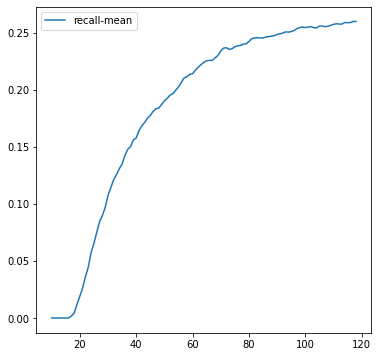

In [17]:
cv[10:].plot(figsize=(6, 6), y=['recall-mean'])
print(cv.loc[cv['recall-mean'].values.argmax()])
trees = cv['recall-mean'].values.argmax()
trees

In [18]:
params['n_estimators'] = trees

In [19]:
feature_importance = []

for booster in cvbooster.boosters:
    feature_importance_ = pd.Series(
        data=booster.feature_importance('split'),
        index=booster.feature_name(),
    )
    feature_importance.append(feature_importance_)
    
feature_importance = pd.concat(feature_importance, axis=1)

feature_importance_mean = feature_importance.median(axis=1).astype(int).rename('mean')
feature_importance_std = feature_importance.std(axis=1).rename('std')

indices = feature_importance_mean.argsort()
feature_importance = feature_importance.iloc[indices]
feature_importance_mean = feature_importance_mean[indices]
feature_importance_std = feature_importance_std[indices]

feature_importance_mean[::-1]

feature_4         437
feature_6         431
feature_3         416
feature_9         365
region_cd         360
feature_5         341
feature_8         331
client_segment    317
feature_2         277
feature_7         263
feature_10        249
feature_1         230
contacts          127
Name: mean, dtype: int64

In [20]:
feature_importance = []

for booster in cvbooster.boosters:
    feature_importance_ = pd.Series(
        data=booster.feature_importance('gain'),
        index=booster.feature_name(),
    )
    feature_importance.append(feature_importance_)
    
feature_importance = pd.concat(feature_importance, axis=1)

feature_importance_mean = feature_importance.mean(axis=1).rename('mean')
feature_importance_std = feature_importance.std(axis=1).rename('std')

indices = feature_importance_mean.argsort()
feature_importance = feature_importance.iloc[indices]
feature_importance_mean = feature_importance_mean[indices]
feature_importance_std = feature_importance_std[indices]

feature_importance_mean[::-1]

client_segment    18628.440341
feature_4          8550.196779
feature_9          3712.822872
feature_5          3627.131333
feature_6          3467.237450
feature_2          2985.725442
feature_3          2305.553960
feature_8          1682.869029
region_cd          1662.232360
feature_1          1603.663209
feature_7          1246.156893
feature_10         1156.288115
contacts            962.866676
Name: mean, dtype: float64

<AxesSubplot:>

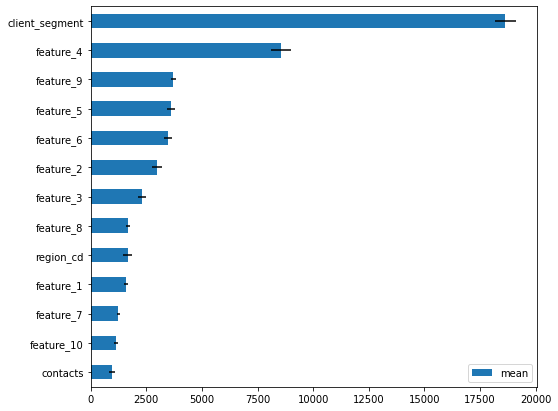

In [21]:
pd.concat([
    feature_importance_mean,
    feature_importance_std,
], axis=1).iloc[-30:].plot.barh(y='mean', figsize=(8, 7), xerr='std')

<AxesSubplot:>

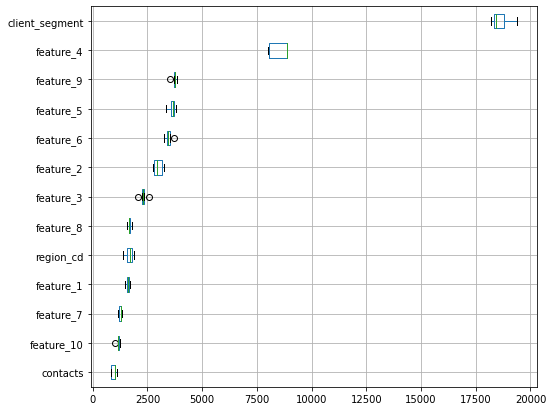

In [22]:
feature_importance.iloc[-30:].T.boxplot(figsize=(8, 7), vert=False)

In [23]:
from scorer_mod import calculate_metric

In [24]:
submission_pull = []

for (_, valid_idx), booster in zip(kfold.split(df, df[target]), cvbooster.boosters):
#     X_train, y_train = df.loc[:, features].iloc[train_idx], df.loc[:, target].iloc[train_idx]
    ids_valid, X_valid, y_valid = (
        df.loc[:, client_id].iloc[valid_idx],
        df.loc[:, features].iloc[valid_idx],
        df.loc[:, target].iloc[valid_idx],
    )
    
    submission = pd.DataFrame(index=ids_valid.values.ravel())
    submission.index = submission.index.rename('client_id')
    submission['target'] = (booster.predict(X_valid) > 0.5).astype(int)
    
    submission_pull.append(submission)
    
submission = pd.concat(submission_pull, axis=0)
submission.head()

,target
client_id,
9157009756404187626,0
-2918739578801888500,1
-330127410754871235,0
377141127543547866,0
-4976026508164850392,0


In [25]:
submission.to_csv('submssion_example.csv', index=True)

In [26]:
calculate_metric('../data/funnel.csv', 'submssion_example.csv')

/home/v.bugaevskii/idao-2021-2/notebooks/scorer_mod.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['gain'] = selected[SALE_FLAG] * selected[SALE_AMOUNT].fillna(0) - selected[CONTACTS] * CALL_COST


35747.12439919894